# Multi-task model

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
import CCLE_utils
import MMRF_utils

## Load cell line data

In [16]:
crispr_rnaseq_merged = pd.read_csv('rnaseq_crispr_merged.csv')
crispr_rnaseq_merged = crispr_rnaseq_merged.drop(columns = ['DepMap_ID'])

In [ ]:
# lenal_df = pd.read_csv('lenalidomide_crispr_knockout.csv')
# bortez_df = pd.read_csv('bortezomib_crispr_knockout.csv')

In [17]:
map_dict = CCLE_utils.get_map_dict('Ensembl_HGNC_map_042421.csv')

In [19]:
response_cols = [col for col in crispr_rnaseq_merged.columns if '_y' in col]
crispr = crispr_rnaseq_merged[response_cols]
rnaseq = crispr_rnaseq_merged.drop(response_cols, axis=1)

In [47]:
print(len(crispr.columns))
print(len(rnaseq.columns))
rnaseq = CCLE_utils.hgnc_to_ensembl(rnaseq, map_dict)
print(len(rnaseq.columns))
rnaseq.head()

13
18971
18914


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000255800,ENSG00000255963,ENSG00000256049,ENSG00000256515,ENSG00000257019,ENSG00000258389,ENSG00000266949,ENSG00000267596,ENSG00000269028,ENSG00000273439
0,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,3.832890,...,0.0,0.000000,0.000000,0.000000,0.0,0.028569,0.042644,0.000000,0.310340,1.618239
1,5.726831,0.000000,7.086189,2.543496,3.102658,0.000000,5.914565,6.099716,4.475733,4.294253,...,0.0,0.014355,0.042644,0.000000,0.0,0.000000,0.863938,0.056584,0.298658,2.111031
2,0.097611,0.000000,5.919102,3.983678,3.733354,0.028569,6.111240,2.963474,3.415488,4.820690,...,0.0,0.000000,0.000000,1.427606,0.0,0.028569,0.028569,0.000000,1.124328,2.042644
3,4.712596,0.000000,6.406333,2.247928,3.032101,0.028569,0.097611,5.528571,6.383704,3.973611,...,0.0,0.111031,0.000000,0.042644,0.0,0.042644,0.014355,0.000000,0.545968,1.427606
4,4.463361,0.042644,6.714658,1.847997,3.171527,0.622930,6.975905,6.993788,4.234961,3.767655,...,0.0,0.070389,0.000000,0.084064,0.0,0.000000,2.056584,0.000000,0.555816,1.627607


In [48]:
X_train, X_test, y_train, y_test = train_test_split(rnaseq,crispr,random_state=42, train_size=0.7)

In [49]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(560, 18914) (240, 18914) (560, 13) (240, 13)


In [ ]:
from sklearn.decomposition import PCA

nPCA = 500
pca = PCA(n_components=nPCA)
X_lenal_cell_train_pca = pca.fit_transform(X_lenal_cell_train)
X_lenal_cell_test_pca = pca.transform(X_lenal_cell_test)

print(X_lenal_cell_train_pca.shape, X_lenal_cell_test_pca.shape)

In [ ]:
nPCA = 500
pca = PCA(n_components=nPCA)
X_bortez_cell_train_pca = pca.fit_transform(X_bortez_cell_train)
X_bortez_cell_test_pca = pca.transform(X_bortez_cell_test)

print(X_bortez_cell_train_pca.shape, X_bortez_cell_test_pca.shape)

# Load patient data

In [39]:
train_patient_all = pd.DataFrame()
valid_patient_all = pd.DataFrame()
test_patient_all = pd.DataFrame()

for ind in [1]:
    data_filename = './data/cleaned_mm%d_2mos_pfs_ind.pkl'%(ind)
    train, test, valid = MMRF_utils.get_train_test_valid(data_filename, ind, show_features=True)

    print('\nPreprocess patient data in MMRF')
    # include the first n clinical visit data for each patient (default 0)
    train_df = MMRF_utils.preprocess_patient_data(train, num_clin_visits=3)  
    print(train_df.shape)

    valid_df = MMRF_utils.preprocess_patient_data(valid, num_clin_visits=3)  
    print(valid_df.shape)

    test_df = MMRF_utils.preprocess_patient_data(test, num_clin_visits=3)  
    print(test_df.shape)

    print('\nPreprocess patient genomic data in MMRF...')
    genomic_fn = './data/MMRF_CoMMpass_IA15a_E74GTF_Salmon_Gene_TPM.txt'
    genomic_df = MMRF_utils.preprocess_genomic_data(genomic_fn, nPCA=0)
    print(genomic_df.shape)

    print('\nMerging patient data with genomic data...')
    train_patient_all = train_patient_all.append(train_df.merge(genomic_df, left_on='pids', right_on='pids'))

    valid_patient_all = valid_patient_all.append(valid_df.merge(genomic_df, left_on='pids', right_on='pids'))

    test_patient_all = test_patient_all.append(test_df.merge(genomic_df, left_on='pids', right_on='pids'))

loading from: ./data/cleaned_mm1_2mos_pfs_ind.pkl
pids
(494,)
x
(494, 33, 16)
m
(494, 33, 16)
feature_names_x
(16,)
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']
ys_seq
(494, 1)
ce
(494, 1)
feature_names_y
(1,)
['progression free survival (all)']
b
(494, 16)
feature_names
(16,)
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
a
(494, 33, 9)
m_a
(494, 33, 6)
feature_names_a
(9,)
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']

Preprocess patient data in MMRF
Keep first 3 clinical visits.
(461, 93)
Keep first 3 clinical visits.
(161, 93)
Keep first 3 clinical visits.
(214, 93)

Preprocess patient genomic data 

In [42]:
test_patient_all.columns

Index(['pids', 'pfs', 'iss', 'age', 'gender', 'ecog',
       'serum_beta2_microglobulin', 'PC1', 'PC2', 'PC3',
       ...
       'ERCC-00157', 'ERCC-00158', 'ERCC-00160', 'ERCC-00162', 'ERCC-00163',
       'ERCC-00164', 'ERCC-00165', 'ERCC-00168', 'ERCC-00170', 'ERCC-00171'],
      dtype='object', length=58090)

In [50]:
len(genomic_df.columns)

genomic_df.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ERCC-00158,ERCC-00160,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,pids
0,0.747555,0.0,16.48200,3.530600,1.153110,0.052192,0.070314,23.97170,5.37230,9.59376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MMRF_1839
1,1.211520,0.0,15.63870,1.199950,0.242032,0.208332,0.093566,7.65518,2.32189,3.95827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MMRF_1686
2,0.182203,0.0,9.85284,2.516850,0.691931,0.074189,1.418730,6.32505,3.35012,4.19819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MMRF_2253
3,1.244470,0.0,14.15190,2.235840,0.411901,0.119781,0.045729,14.40730,3.68360,5.30710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MMRF_2180
4,1.064230,0.0,5.43182,0.833239,0.194672,0.028010,0.201745,4.05475,3.11611,2.67983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MMRF_2680


In [ ]:
#place holder patient data: 50 samples with 5000 genes
X_pt_train = np.random.rand(50,5000)*80
y_pt_train = X_pt_train.mean(axis=1)+np.random.rand(50,)*40

In [ ]:
X_pt_test = np.random.rand(10,5000)*80
y_pt_test = X_pt_test.mean(axis=1)+np.random.rand(10,)*40

# Autoencoder

In [54]:
def get_autoencoder(encoding_dim):
    out_shape = X_train.shape[1]
    # This is our input image
    input_rna = K.layers.Input(shape=(out_shape,))

    # "encoded" is the encoded representation of the input
    encoded = K.layers.Dense(4*encoding_dim, activation='relu')(input_rna)
    encoded = K.layers.Dense(2*encoding_dim, activation='relu')(encoded)
    encoded = K.layers.Dense(encoding_dim, activation=None)(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = K.layers.Dense(4*encoding_dim, activation='relu')(encoded)                                                          
    decoded = K.layers.Dense(2*encoding_dim, activation='relu')(decoded)
    decoded = K.layers.Dense(out_shape, activation=None)(decoded)

    # This model maps an input to its reconstruction
    autoencoder = K.models.Model(input_rna, decoded)
    autoencoder.compile(optimizer='adam', loss='MSE')
    
    return autoencoder

In [55]:
mmrf_ae = get_autoencoder(64)
mmrf_ae.fit(X_train, X_train,
                epochs=300,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=0)

Text(0, 0.5, 'Predicted Component')

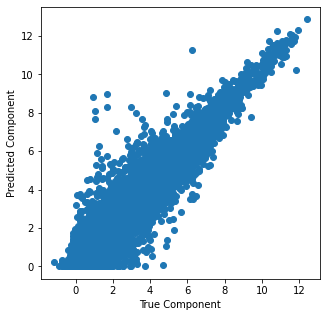

In [56]:
plt.figure(figsize=(5,5))
plt.scatter(mmrf_ae.predict(np.array(X_test)[0:1,:]),np.array(X_test)[0:1,:])
plt.xlabel('True Component')
plt.ylabel('Predicted Component')
plt.title('Autoencoder Results')

In [ ]:
print(sklearn.metrics.)

In [58]:
print(len(set(rnaseq.columns).intersection(set(genomic_df.columns))))
print(len(rnaseq.columns), len(genomic_df.columns))

18914
18914 57998


In [72]:
def mmrf_ae_encode(rna_data):
    encoder = K.models.Model(inputs=mmrf_ae.input, outputs=mmrf_ae.layers[2].output)
    encoded = encoder(np.array(rna_data))
    return encoded

In [84]:
print(rnaseq.shape)
encoded = mmrf_ae_encode(rnaseq)
print(encoded.shape)

(800, 18914)
(800, 128)


In [88]:
print(np.array(encoded))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [89]:
X_enc_train, X_enc_test, y_crispr_train, y_crispr_test = train_test_split(np.array(encoded),crispr,random_state=42, train_size=0.7)

In [91]:
print(X_enc_train.shape, X_enc_test.shape, y_crispr_train.shape, y_crispr_test.shape)

(560, 128) (240, 128) (560, 13) (240, 13)


In [144]:
print(type(y_crispr_train))

<class 'pandas.core.frame.DataFrame'>


# Train NN on cell line

In [96]:
# number of genes 
# N_in = X_cell_train.shape[1]

# N_in : number of genes input



def generate_model(N_in, N_out, shapes):
    inputs = K.layers.Input(shape = (N_in,))
    x = K.layers.Dropout(0.2, input_shape=(N_in,))(inputs)
    x = K.layers.Dense(shapes, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001))(x)
    x = K.layers.Dropout(0.5)(x)
    x = K.layers.Dense(128, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001))(x)
    x = K.layers.Dropout(0.5)(x)
    x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001))(x)
    y1 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y1')(x)
    y2 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y2')(x)
    y3 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y3')(x)
    y4 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y4')(x)
    y5 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y5')(x)
    y6 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y6')(x)
    y7 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y7')(x)
    y8 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y8')(x)
    y9 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y9')(x)
    y10 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y10')(x)
    y11 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y11')(x)
    y12 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y12')(x)
    y13 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y13')(x)

    model = K.models.Model(inputs = inputs, outputs = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13])
    model.compile(optimizer='adam',
                  loss=generate_loss(N_out, 'mse'))
    
    return model

In [97]:
def generate_loss(N_out, loss):
    L = dict()
    for i in range(1, N_out+1):
        k = 'y'+str(i)
        L[k] = loss
    return L

In [98]:
# prototype model  
shapes = 1024
model_ = generate_model(128, 13, shapes)
model_.summary()

print("Input", model_.input_shape, "Output", model_.output_shape)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 128)          0           input_10[0][0]                   
__________________________________________________________________________________________________
dense_104 (Dense)               (None, 1024)         132096      dropout_20[0][0]                 
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 1024)         0           dense_104[0][0]                  
___________________________________________________________________________________________

In [122]:
history = model_.fit(X_enc_train,y_crispr_train,epochs=500, validation_data=(X_enc_test, y_crispr_test),verbose=0)

In [146]:
print(y_crispr_train.shape)
print(type(y_crispr_train))

print(X_enc_train.shape)
print(type(X_enc_train))

(560, 13)
<class 'pandas.core.frame.DataFrame'>
(560, 128)
<class 'numpy.ndarray'>


In [143]:
print(model_.predict(np.expand_dims(X_enc_train[0], axis=0)))

[array([[-0.8142224]], dtype=float32), array([[-0.8138666]], dtype=float32), array([[-0.8141048]], dtype=float32), array([[-0.8139104]], dtype=float32), array([[-0.8134191]], dtype=float32), array([[-0.8143194]], dtype=float32), array([[-0.8146649]], dtype=float32), array([[-0.81397027]], dtype=float32), array([[-0.814299]], dtype=float32), array([[-0.8143512]], dtype=float32), array([[-0.81376445]], dtype=float32), array([[-0.81457436]], dtype=float32), array([[-0.8137601]], dtype=float32)]


In [128]:
from sklearn.decomposition import PCA

nPCA = 500
pca = PCA(n_components=nPCA)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape, X_test_pca.shape)

(560, 500) (240, 500)


In [129]:
model_pca = generate_model(500, 13, 1024)
pca_history = model_pca.fit(X_train_pca,y_crispr_train,epochs=500, validation_data=(X_test_pca, y_crispr_test),verbose=0)

# Eval performance on cell line test set

In [123]:
def plot_loss(perf_dict):
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    loss = perf_dict['loss']
    val_loss = perf_dict['val_loss']
    ax1.plot(loss)
    ax2.plot(val_loss)
    ax1.set_xlabel('epochs')
    ax2.set_xlabel('epochs')

    ax1.set_ylabel('loss')
    ax2.set_ylabel('val_loss')
    plt.show()

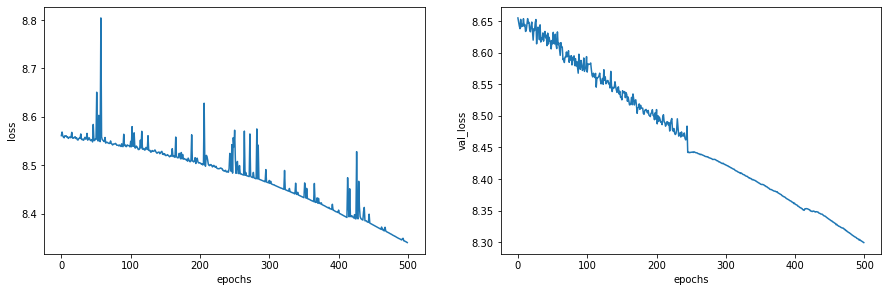

In [124]:
plot_loss(history.history)

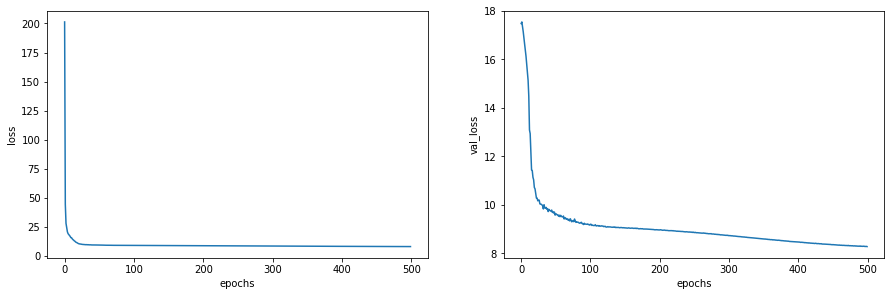

In [130]:
plot_loss(pca_history.history)

Text(0.5, 1.0, 'CRISPR Knockout Experiments - AE')

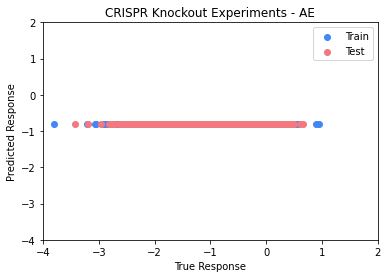

In [135]:
# plt.scatter(y_cell_test,model.predict(X_cell_test))
# x = np.arange(-1.5,1.1,0.01)
fig, ax = plt.subplots(1,1)
# ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_crispr_train.T,np.array(model_.predict(X_enc_train))[:,:,0], label='Train', color='#4287f5')
ax.scatter(y_crispr_test.T,np.array(model_.predict(X_enc_test))[:,:,0], label='Test', color='#f2797f')
ax.set_xlim(-4,2)
ax.set_ylim(-4,2)
ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - AE')

Text(0.5, 1.0, 'CRISPR Knockout Experiments - PCA')

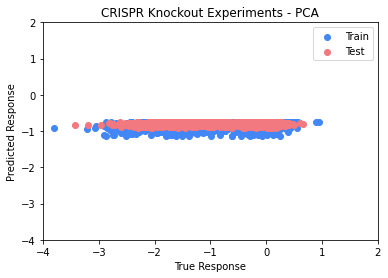

In [132]:
# plt.scatter(y_cell_test,model.predict(X_cell_test))
# x = np.arange(-1.5,1.1,0.01)
fig, ax = plt.subplots(1,1)
# ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_crispr_train.T,np.array(model_pca.predict(X_train_pca))[:,:,0], label='Train', color='#4287f5')
ax.scatter(y_crispr_test.T,np.array(model_pca.predict(X_test_pca))[:,:,0], label='Test', color='#f2797f')
ax.set_xlim(-4,2)
ax.set_ylim(-4,2)
ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - PCA')

In [115]:
print(np.array(model_.predict(X_enc_train))[:,:,0].shape)
print(y_crispr_train.T.shape)

(13, 560)
(13, 560)


In [ ]:
# plt.scatter(y_cell_test,model.predict(X_cell_test))
x = np.arange(-1.5,1.1,0.01)
fig, ax = plt.subplots(1,1)
ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_lenal_cell_train,pca_model.predict(X_lenal_cell_train_pca), label='Train', color='#4287f5')
ax.scatter(y_lenal_cell_test,pca_model.predict(X_lenal_cell_test_pca), label='Test', color='#f2797f')
# ax.set_xlim(-7,-2)
# ax.set_ylim(-7,-2)
ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Lenalidomide with PCA')

In [ ]:
# plt.scatter(y_cell_test,model.predict(X_cell_test))
x = np.arange(-3,0.6,0.01)
fig, ax = plt.subplots(1,1)
ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_bortez_cell_train,pca_model2.predict(X_bortez_cell_train_pca), label='Train', color='#4287f5')
ax.scatter(y_bortez_cell_test,pca_model2.predict(X_bortez_cell_test_pca), label='Test', color='#f2797f')
# ax.set_xlim(-7,-2)
# ax.set_ylim(-7,-2)
ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Bortezomib with PCA')

In [ ]:
# plt.scatter(y_cell_test,model.predict(X_cell_test))
# x = np.arange(-1.5,1.1,0.01)
fig, ax = plt.subplots(1,1)
# ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_bortez_cell_train,bortez_model.predict(X_bortez_cell_train), label='Train', color='#4287f5')
ax.scatter(y_bortez_cell_test,bortez_model.predict(X_bortez_cell_test), label='Test', color='#f2797f')
# ax.set_xlim(-7,-2)
# ax.set_ylim(-7,-2)
ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Bortezomib')

In [ ]:
# plt.scatter(y_cell_test,model.predict(X_cell_test))
# x = np.arange(-1.5,1.1,0.01)
fig, ax = plt.subplots(1,1)
# ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_bortez_cell_train,bortez_model.predict(X_bortez_cell_train), label='Train', color='#4287f5')
ax.scatter(y_bortez_cell_test,bortez_model.predict(X_bortez_cell_test), label='Test', color='#f2797f')
# ax.set_xlim(-7,-2)
# ax.set_ylim(-7,-2)
ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Bortezomib')

# Feature transfer patient data
Freeze network except the last layer, then train on patient data

In [ ]:
model.summary()

In [ ]:
model.trainable = False
model.layers[-1].trainable = True

layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])      

In [ ]:
history_pt = model.fit(X_pt_train, y_pt_train, epochs=100, validation_data=(X_pt_test, y_pt_test))

In [ ]:
plt.scatter(y_pt_test,model.predict(X_pt_test))

# Save model

In [ ]:
model = K.models.load_model(model_dir)

In [ ]:
model_dir = os.path.join('6.871models', 'simpleNN042721')
shutil.rmtree(model_dir)
model.save(model_dir)
